# `mdmm` tutorial
The purpose of this notebook is to guide you to train a model with a loss function of several parameters in a proper mathematical way. The idea comes from the paper [Constrained Differential Optimization](https://papers.nips.cc/paper/1987/file/a87ff679a2f3e71d9181a67b7542122c-Paper.pdf), and the implementation from the [mdmm package Github](https://github.com/crowsonkb/mdmm)

The guide is best illustrated through the **[VICReg](https://arxiv.org/abs/2105.04906)** example where your input is split into two views and you are asked to minimize three loss terms: `variance`, `invariance` and `covariance`.

In [53]:
! pip install mdmm

In [54]:
import warnings
import numpy as np
import mdmm
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

import copy
import glob
import os
from pathlib import Path

from torch.utils.data import DataLoader

warnings.simplefilter("ignore", UserWarning)

# define the global base device
if torch.cuda.device_count():
    device = torch.device("cuda:0")
    print(f"Will use {torch.cuda.get_device_name(device)}")
else:
    device = "cpu"
    print("Will use cpu")

Will use NVIDIA GeForce GTX 1080 Ti


In [55]:
# !nvidia-smi -q

Load a processed `.pt` clic file.

In [56]:
data = torch.load("/../ssl-jet-vol-v2/toptagging/train/processed/3_features/data_0.pt")
print(f"num of clic events {len(data)}")

num of clic events 100001


In [57]:
# build a data loader
batch_size = 128

loader = DataLoader(data, batch_size, shuffle=True)
for batch in loader:
    print(f"A single event: \n {batch.shape}")
    break

A single event: 
 torch.Size([128, 3, 50])


# Preparation

In [58]:
from src.models.jet_augs import *

In [59]:
def augmentation(batch, device="cpu"):
    """
    Takes events of the form Batch() and applies a series of augmentations. 
    The output will have the same shape as the input
    """
    batch_aug = translate_jets(batch, device=device)
    batch_aug = rotate_jets(batch_aug, device=device)
    return batch_aug

In [60]:
def event_augmentation(batch, device="cpu"):
    """
    Takes events of the form Batch() and splits them into two Batch() objects representing the two views.

    In this example, the two views are translated and then rotated by different amounts
    """
    view1 = augmentation(batch, device=device)
    view2 = augmentation(batch, device=device)

    return view1, view2

In [61]:
# view1, view2 = event_augmentation(batch, device)
# print(f"view1: {view1}")
# print(f"view2: {view2}")

In [62]:
# view1.x

In [63]:
# print(view2[10])

In [64]:
# print(view1[0].x[:3])

# Setup the VICReg model (Transformer-based)
https://github.com/bmdillon/JetCLR/blob/main/scripts/modules/transformer.py

In [65]:
from src.models.transformer import Transformer

In [66]:
class VICReg(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.num_features = int(
            args.mlp.split("-")[-1]
        )  # size of the last layer of the MLP projector
        self.x_transform = nn.Sequential(
            nn.BatchNorm1d(args.x_inputs),
            nn.Linear(args.x_inputs, args.transform_inputs),
            nn.BatchNorm1d(args.transform_inputs),
            nn.ReLU(),
        )
        self.y_transform = nn.Sequential(
            nn.BatchNorm1d(args.y_inputs),
            nn.Linear(args.y_inputs, args.transform_inputs),
            nn.BatchNorm1d(args.transform_inputs),
            nn.ReLU(),
        )
        self.augmentation = args.augmentation
        self.x_backbone = args.x_backbone
        self.y_backbone = args.y_backbone
        self.N_x = self.x_backbone.input_dim
        self.N_y = self.y_backbone.input_dim
        self.embedding = args.Do
        self.return_embedding = args.return_embedding
        self.return_representation = args.return_representation
        self.x_projector = Projector(args.mlp, self.embedding)
        self.y_projector = (
            self.x_projector if args.shared else copy.deepcopy(self.x_projector)
        )

    def forward(self, x):
        """
        x -> x_aug -> (x_xform) -> x_rep -> x_emb
        y -> y_aug -> (y_xform) -> y_rep -> y_emb
        _aug: augmented
        _xform: transformed by linear layer (skipped because it destroys the zero padding)
        _rep: backbone representation
        _emb: projected embedding
        """
        x_aug, y_aug = self.augmentation(
            self.args, x, self.args.device
        )  # [batch_size, n_constit, 3]
#         print(f"x_aug contains nan: {contains_nan(x_aug)}")
#         print(f"y_aug contains nan: {contains_nan(y_aug)}")

        # x_xform = self.x_transform.to(torch.double)(
        #     x_aug.x.double()
        # )  # [batch_size, n_constit, transform_inputs]?
        # y_xform = self.y_transform.to(torch.double)(
        #     y_aug.x.double()
        # )  # [batch_size, n_constit, transform_inputs]?

        x_rep = self.x_backbone(
            x_aug, use_mask=self.args.mask, use_continuous_mask=self.args.cmask
        )  # [batch_size, output_dim]
        y_rep = self.y_backbone(
            y_aug, use_mask=self.args.mask, use_continuous_mask=self.args.cmask
        )  # [batch_size, output_dim]
#         print(f"x_rep contains nan: {contains_nan(x_rep)}")
#         print(f"y_rep contains nan: {contains_nan(y_rep)}")
        if self.return_representation:
            return x_rep, y_rep

        x_emb = self.x_projector(x_rep)  # [batch_size, embedding_size]
        y_emb = self.y_projector(y_rep)  # [batch_size, embedding_size]
#         print(f"x_emb contains nan: {contains_nan(x_emb)}")
#         print(f"y_emb contains nan: {contains_nan(y_emb)}")
        if self.return_embedding:
            return x_emb, y_emb
        x = x_emb
        y = y_emb
        repr_loss = F.mse_loss(x, y)

        x = x - x.mean(dim=0)
        y = y - y.mean(dim=0)

        std_x = torch.sqrt(x.var(dim=0) + 0.0001)
        std_y = torch.sqrt(y.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        cov_x = (x.T @ x) / (self.args.batch_size - 1)
        cov_y = (y.T @ y) / (self.args.batch_size - 1)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(
            self.num_features
        ) + off_diagonal(cov_y).pow_(2).sum().div(self.num_features)

        loss = (
            self.args.sim_coeff * repr_loss
            + self.args.std_coeff * std_loss
            + self.args.cov_coeff * cov_loss
        )
        if args.return_all_losses:
            return loss, repr_loss, std_loss, cov_loss
        else:
            return loss

In [67]:
def Projector(mlp, embedding):
    mlp_spec = f"{embedding}-{mlp}"
    layers = []
    f = list(map(int, mlp_spec.split("-")))
    for i in range(len(f) - 2):
        layers.append(nn.Linear(f[i], f[i + 1]))
        layers.append(nn.BatchNorm1d(f[i + 1]))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(f[-2], f[-1], bias=False))
    return nn.Sequential(*layers)


def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()


def get_backbones(args):
    x_backbone = Transformer(input_dim=args.x_inputs)
    y_backbone = x_backbone if args.shared else copy.deepcopy(x_backbone)
    return x_backbone, y_backbone


def augmentation(args, x, device):
    """
    Applies all the augmentations specified in the args
    """
    # cropping to 50 particles is already done in data preprocessing
    # crop all jets to a fixed number of constituents (default=50)
#     x = crop_jets(x, args.nconstit)
    x = rotate_jets(x, device)
    y = x.clone()
    if args.do_rotation:
        y = rotate_jets(y, device)
    if args.do_cf:
        y = collinear_fill_jets(np.array(y.cpu()), device)
        y = collinear_fill_jets(np.array(y.cpu()), device)
    if args.do_ptd:
        y = distort_jets(y, device, strength=args.ptst, pT_clip_min=args.ptcm)
    if args.do_translation:
        y = translate_jets(y, device, width=args.trsw)
        x = translate_jets(x, device, width=args.trsw)
    x = rescale_pts(x)  # [batch_size, 3, n_constit]
    y = rescale_pts(y)  # [batch_size, 3, n_constit]
    x = x.transpose(1, 2)  # [batch_size, 3, n_constit] -> [batch_size, n_constit, 3]
    y = y.transpose(1, 2)  # [batch_size, 3, n_constit] -> [batch_size, n_constit, 3]
    return x, y


# load the datafiles
def load_data(dataset_path, flag, n_files=-1):
    data_files = glob.glob(f"{dataset_path}/{flag}/processed/3_features/*")

    data = []
    for i, file in enumerate(data_files):
        data += torch.load(f"{dataset_path}/{flag}/processed/3_features/data_{i}.pt")
        print(f"--- loaded file {i} from `{flag}` directory")
        if n_files != -1 and i == n_files - 1:
            break

    return data

In [68]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])

In [69]:
project_dir = "/ssl-jet-vol-v2/JetCLR_VICReg"
args.mask = False
args.cmask = True
args.epoch = 10
args.batch_size = 256
args.outdir = f"{project_dir}/models/"
args.label = "notebook_test"
args.dataset_path = "/ssl-jet-vol-v2/toptagging"
args.num_train_files = 1
args.num_val_files = 1
args.shared = False
args.mlp = "256-256-256"
args.transform_inputs = 32
args.Do = 1000
args.hidden = 128
args.sim_coeff = 25.0
args.std_coeff = 25.0
args.cov_coeff = 1.0
args.return_embedding = True
args.return_representation = False
args.do_translation = True
args.do_rotation = True
args.do_cf = True
args.do_ptd = True
args.nconstit = 50
args.ptst = 0.1
args.ptcm = 0.1
args.trsw = 1.0
args.return_all_losses = True

# Setup the loss terms

In [70]:
def off_diagonal(x):
    """Copied from VICReg paper github https://github.com/facebookresearch/vicreg/"""
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()


class CovLoss(nn.Module):
    def forward(self, view1, view2):
        N = view1.size(0)  # batch size
        D = view1.size(1)  # dim of representations

        view1 = view1 - view1.mean(dim=0)
        view2 = view2 - view2.mean(dim=0)

        cov_view1 = (view1.T @ view1) / (N - 1)
        cov_view2 = (view2.T @ view2) / (N - 1)

        loss = off_diagonal(cov_view1).pow_(2).sum().div(D) + off_diagonal(cov_view2).pow_(2).sum().div(D)
        return loss


class VarLoss(nn.Module):
    def forward(self, view1, view2):
        view1 = view1 - view1.mean(dim=0)
        view2 = view2 - view2.mean(dim=0)

        # variance loss
        std_view1 = torch.sqrt(view1.var(dim=0) + 1e-10)
        std_view2 = torch.sqrt(view2.var(dim=0) + 1e-10)

        loss = torch.mean(F.relu(1 - std_view1)) / 2 + torch.mean(F.relu(1 - std_view2)) / 2
        return loss

In [71]:
args.augmentation = augmentation
args.device = device

args.x_inputs = 3
args.y_inputs = 3

args.x_backbone, args.y_backbone = get_backbones(args)
model = VICReg(args).to(args.device)

In [141]:
crit_invar = nn.MSELoss()
crit_var = VarLoss()
crit_cov = CovLoss()

max_var = 0.5 * batch_size
max_cov = 0.5 * batch_size

constraints = []
constraints.append(mdmm.MaxConstraintHard(lambda: crit_var(view1_embeddings, view2_embeddings), max_var, scale=1e-10))
constraints.append(mdmm.MaxConstraintHard(lambda: crit_cov(view1_embeddings, view2_embeddings), max_cov))
# constraints.append(mdmm.MaxConstraint(lambda: crit_cov(view1_embeddings, view2_embeddings), max_cov, scale=1e4))

mdmm_module = mdmm.MDMM(constraints).to(device)
optimizer = mdmm_module.make_optimizer(model.parameters(), lr=1e-4)

In [142]:
1e3*0.43

430.0

# Run a training loop

In [143]:
losses_inv, losses_var, losses_cov, losses_reg = [], [], [], []
print(f"max var: {max_var}")
print(f"max cov: {max_cov}")
for i, batch in enumerate(loader):
    print(f"batch {i}")
    # run VICReg forward pass to get the embeddings
    view1_embeddings, view2_embeddings = model(batch.to(device))
#     print(f"view1_embeddings size: {view1_embeddings.size()}")

    # compute the invariance loss which is contrained by the other loss terms
    loss = batch_size * crit_invar(view1_embeddings, view2_embeddings)
    print(f"invariance loss: {loss:.2f}")
    losses_inv.append(loss.detach().item())
    loss_var = batch_size * crit_var(view1_embeddings, view2_embeddings)
    print(f"variance loss: {loss_var:.2f}")
    losses_var.append(loss_var.detach().item())
    loss_cov = batch_size * crit_cov(view1_embeddings, view2_embeddings)
    print(f"covariance loss: {loss_cov:.2f}")
    losses_cov.append(loss_cov.detach().item())


    mdmm_return = mdmm_module(loss.to(device))

    # backprop
    for param in model.parameters():
        param.grad = None
    mdmm_return.value.backward()

    optimizer.step()
    print(f"constrained invariance loss: {loss.detach():.2f}")
    losses_reg.append(loss.detach().item())

    if i == 30:
        break
    print("-----------")

max var: 64.0
max cov: 64.0
batch 0
invariance loss: 0.17
variance loss: 124.78
covariance loss: 0.00
constrained invariance loss: 0.17
-----------
batch 1
invariance loss: 0.86
variance loss: 120.98
covariance loss: 0.15
constrained invariance loss: 0.86
-----------
batch 2
invariance loss: 0.64
variance loss: 122.38
covariance loss: 0.07
constrained invariance loss: 0.64
-----------
batch 3
invariance loss: 0.69
variance loss: 121.96
covariance loss: 0.11
constrained invariance loss: 0.69
-----------
batch 4
invariance loss: 0.39
variance loss: 123.22
covariance loss: 0.02
constrained invariance loss: 0.39
-----------
batch 5
invariance loss: 0.40
variance loss: 123.13
covariance loss: 0.02
constrained invariance loss: 0.40
-----------
batch 6
invariance loss: 0.34
variance loss: 123.50
covariance loss: 0.01
constrained invariance loss: 0.34
-----------
batch 7
invariance loss: 0.62
variance loss: 122.35
covariance loss: 0.07
constrained invariance loss: 0.62
-----------
batch 8
inva

In [144]:
mdmm_return

MDMMReturn(value=tensor(0.3660, device='cuda:0', grad_fn=<AddBackward0>), fn_values=[tensor(0.9654, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)], infs=[tensor(0., device='cuda:0', grad_fn=<SubBackward0>), tensor(0., device='cuda:0', grad_fn=<SubBackward0>)])

In [145]:
mdmm_return.infs

[tensor(0., device='cuda:0', grad_fn=<SubBackward0>),
 tensor(0., device='cuda:0', grad_fn=<SubBackward0>)]

In [146]:
mdmm_return

MDMMReturn(value=tensor(0.3660, device='cuda:0', grad_fn=<AddBackward0>), fn_values=[tensor(0.9654, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)], infs=[tensor(0., device='cuda:0', grad_fn=<SubBackward0>), tensor(0., device='cuda:0', grad_fn=<SubBackward0>)])

In [147]:
# print(f"view1_embeddings size: {view1_embeddings.size()}")

In [148]:
# !nvidia-smi -q

In [149]:
print(f"max var: {max_var}")
print(f"max cov: {max_cov}")

max var: 64.0
max cov: 64.0


Text(0.5, 1.0, 'Unconstrained Invariance loss')

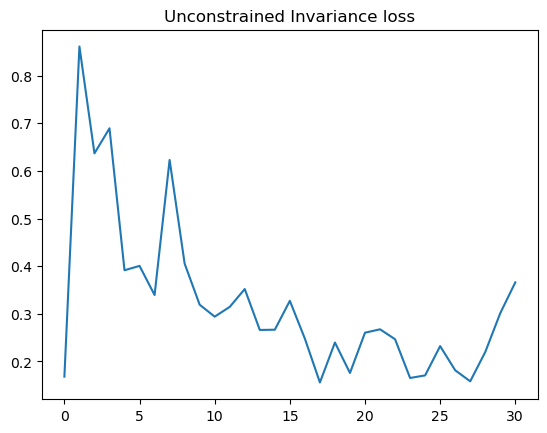

In [150]:
plt.plot(losses_inv)
plt.title("Unconstrained Invariance loss")

Text(0.5, 1.0, 'Variance loss')

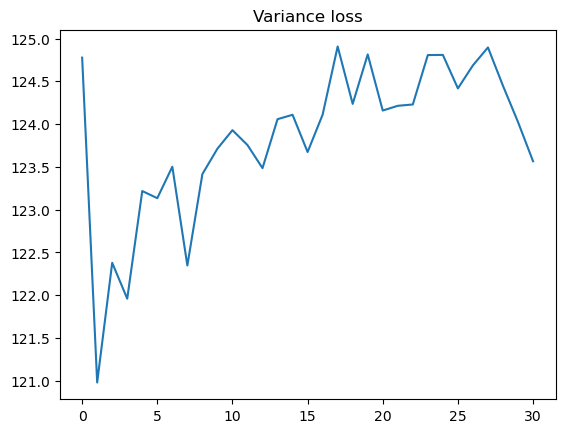

In [151]:
plt.plot(losses_var)
plt.title("Variance loss")

Text(0.5, 1.0, 'Covariance loss')

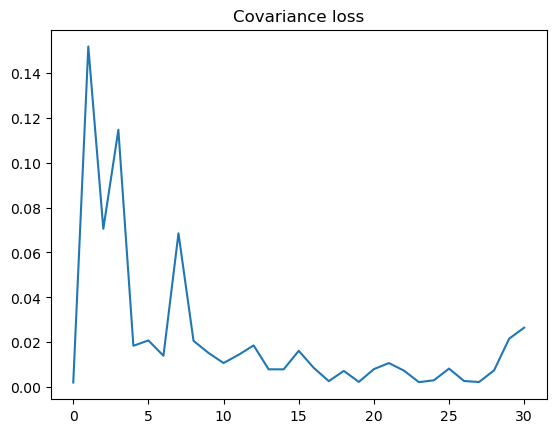

In [152]:
plt.plot(losses_cov)
plt.title("Covariance loss")

Text(0.5, 1.0, 'Constrained Invariance loss')

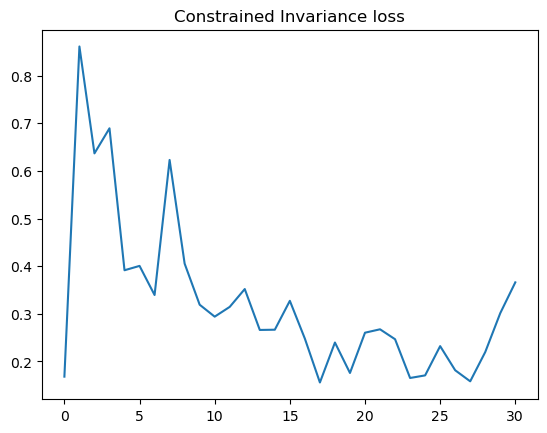

In [153]:
plt.plot(losses_reg)
plt.title("Constrained Invariance loss")